In [1]:
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import stats

In [2]:
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4
plt.rcParams['legend.borderpad'] = 0.5
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=22)

# 1. Генерация данных

In [3]:
def generate_data(sample_size, corr=0.8):
    """Генерируем две выборки с случайным сэмплированием.
    
    sample_size - размер выборки
    corr - корреляция метрики во время эксперимента с метрикой до эксперимента
    
    return - pd.DataFrame со столбцами ['metric', 'metric_before', 'factor'],
        'metric' - значение метрики во время эксперимента,
        'metric_before' - значение метрики до время эксперимента.
    """
    means = [5, 5]
    cov = [[1, corr], [corr, 1]]
    data = np.random.multivariate_normal(means, cov, sample_size)
    df = pd.DataFrame({'metric': data[:, 0], 'metric_before': data[:, 1]})
    return df

In [4]:
df = generate_data(5, 0.6)
df

,metric,metric_before
0,4.364013,5.561109
1,4.295040,4.474431
2,5.514208,7.027549
3,6.210948,6.349229
4,4.645607,5.131041


In [5]:
df.corr().round(3)

,metric,metric_before
metric,1.000,0.787
metric_before,0.787,1.000


# 2. Оценка $\theta$
$$\hat{Y}_{CV} = \overline{Y} - \theta \overline{X} + \theta\mathbb{E}X$$

$$\hat{Y}_{CV, i} = Y_i - \theta X_i + \theta\mathbb{E}X$$


Формула для оптимального значения $\theta$:

$$\theta = \frac{\mathrm{cov}(Y,X)}{\mathbb{V} X}$$

In [6]:
def calculate_theta(y_control, y_pilot, x_control, x_pilot):
    """Вычисляем Theta по данным двух групп.

    y_control - значения метрики во время пилота на контрольной группе
    y_pilot - значения метрики во время пилота на пилотной группе
    x_control - значения ковариант на контрольной группе
    x_pilot - значения ковариант на пилотной группе
    """
    y = np.hstack([y_control, y_pilot])
    x = np.hstack([x_control, x_pilot])
    covariance = np.cov(x, y)[0, 1]
    variance = x.var()
    theta = covariance / variance
    return theta

Посмотрим, как работает функция. Сгенерируем два датасета, к одному из них добавим эффект, вычислим $\theta$.

In [7]:
sample_size = 100
df_control = generate_data(sample_size)
df_pilot = generate_data(sample_size)
df_pilot['metric'] += np.random.normal(0.2, 0.1, sample_size)

theta = calculate_theta(
    df_control['metric'], df_pilot['metric'],
    df_control['metric_before'], df_pilot['metric_before']
)
print(f'theta = {theta}')

theta = 0.7655664946408416


Проверим, действительно ли при таком значении $\theta$ достигается минимум дисперсии. Для этого вычислим преобразованную метрику и построим график её дисперсии в зависимости от $\theta$ для пилотной и контрольной групп.

  0%|          | 0/1000 [00:00<?, ?it/s]

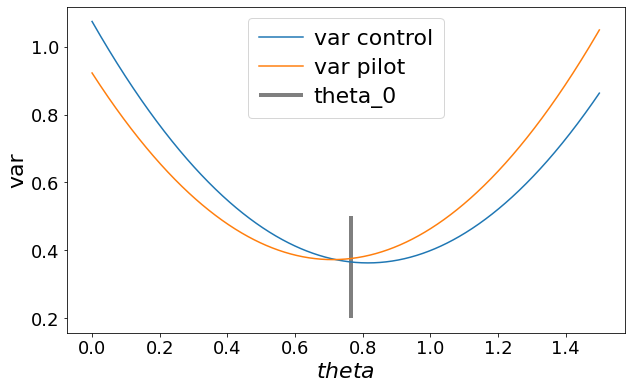

In [8]:
thetas = np.linspace(0, 1.5, 1000)
list_var_control = []
list_var_pilot = []

for theta_ in tqdm(thetas):
    y_cuped_control = df_control['metric'] - theta_ * df_control['metric_before']
    y_cuped_pilot = df_pilot['metric'] - theta_ * df_pilot['metric_before']
    list_var_control.append(y_cuped_control.var())
    list_var_pilot.append(y_cuped_pilot.var())

plt.plot(thetas, list_var_control, label='var control')
plt.plot(thetas, list_var_pilot, label='var pilot')
plt.vlines(theta, 0.2, 0.5, label='theta_0', linewidth=4, alpha=0.5)
plt.xlabel('$theta$')
plt.ylabel('var')
plt.legend()
plt.show()

Действительно, значение $\theta$, найденное по формуле, близко к оптимальным значениям с минимальными дисперсиями.

# 3. Оценка экспериментов

In [9]:
def check_test(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних с помощью t-test.

    return - pvalue.
    """
    values_control = df_control['metric'].values
    values_pilot = df_pilot['metric'].values
    _, pvalue = stats.ttest_ind(values_control, values_pilot)
    return pvalue


def check_cuped_test(df_control, df_pilot, covariate_column):
    """Проверяет гипотезу о равенстве средних с использованием CUPED.

    covariate_column - название стобца с ковариантой

    return - pvalue.
    """
    theta = calculate_theta(
        df_control['metric'], df_pilot['metric'],
        df_control[covariate_column], df_pilot[covariate_column]
    )
    metric_cuped_control = df_control['metric'] - theta * df_control[covariate_column]
    metric_cuped_pilot = df_pilot['metric'] - theta * df_pilot[covariate_column]
    _, pvalue = stats.ttest_ind(metric_cuped_control, metric_cuped_pilot)
    return pvalue

Посмотрим, как работает `check_cuped_test`. Мы создавали пару датафреймов `df_control`, `df_pilot` с наличием эффекта в пилотной группе. Применим `check_test` и `check_cuped_test` к этим данным.

In [10]:
pvalue_ttest = check_test(df_control, df_pilot)
pvalue_cuped = check_cuped_test(df_control, df_pilot, 'metric_before')
print(f'pvalue_ttest = {pvalue_ttest:0.3f}')
print(f'pvalue_cuped = {pvalue_cuped:0.3f}')

pvalue_ttest = 0.743
pvalue_cuped = 0.588


p-value при применении CUPED стало меньше, чувствительность увеличилась.

## Оценка вероятностей ошибок первого рода

Проведём много A/A тестов с различными значениями корреляции целевой метрики и ковариаты, затем построим распределение p-value. P-value должно быть распределено равномерно.

  0%|          | 0/1000 [00:00<?, ?it/s]

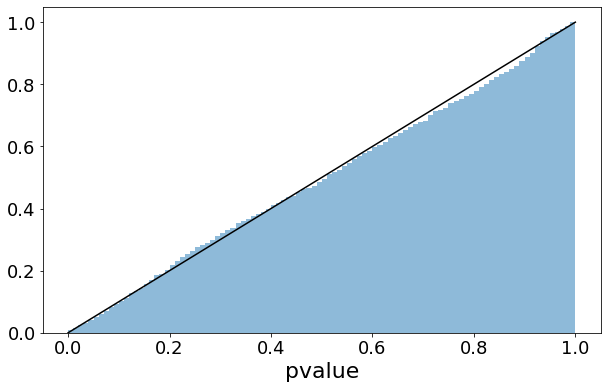

In [11]:
sample_size = 1000
pvalues_cuped = []
corrs = np.random.uniform(-1, 1, 1000)

for corr in tqdm(corrs):
    df_control = generate_data(sample_size, corr)
    df_pilot = generate_data(sample_size, corr)
    pvalues_cuped.append(check_cuped_test(df_control, df_pilot, 'metric_before'))


plt.hist(pvalues_cuped, bins=100, density=True, cumulative=True, alpha=0.5)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.show()

P-value распределено равномерно.

## Сравнение мощности тестов

Проведём много синтетических A/B тестов и построим распределение p-value. Распределение p-value должно быть выпуклым вверх. Чем более оно выпукло, тем мощнее тест.

  0%|          | 0/1000 [00:00<?, ?it/s]

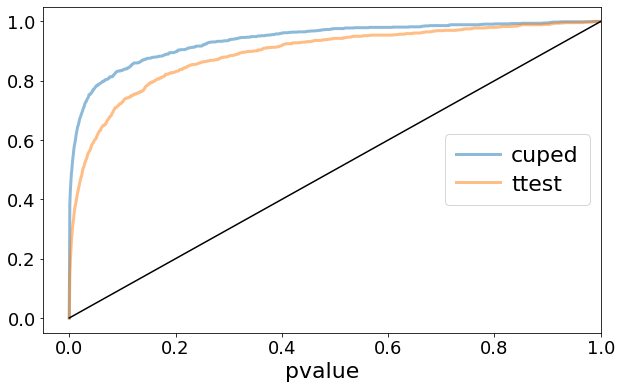

In [12]:
sample_size = 1000
pvalues_ttest = []
pvalues_cuped = []
corrs = np.random.uniform(0.01, 0.99, 1000)

for corr in tqdm(corrs):
    df_control = generate_data(sample_size, corr)
    df_pilot = generate_data(sample_size, corr)
    df_pilot['metric'] += np.random.normal(0.1, 0.01, sample_size)
    pvalues_ttest.append(check_test(df_control, df_pilot))
    pvalues_cuped.append(check_cuped_test(df_control, df_pilot, 'metric_before'))


list_pvalues = [pvalues_ttest, pvalues_cuped]
list_titles = ['ttest', 'cuped']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.xlim([-0.05, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

Критерий с использованием CUPED обладает большей мощностью.

# 4. Данные пиццерии

Рассмотрим пример применения CUPED на данных пиццерии. Допустим, мы провели эксперимент на покупателях — высылали письмо с рекламой после покупки. В эксперимент попали только те, кто делал покупку во время эксперимента. Продолжительность эксперимента — 1 неделя. Метрика — средняя выручка с покупателя.

In [13]:
# загрузка данных
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

df_sales - информация о покупках, одна строка - один заказ. Атрибуты:
- sale_id - идентификатор покупки;
- date - дата покупки;
- count_pizza - количество пицц в заказе;
- count_drink - количество напитков в заказе;
- price - стоимость заказа;
- user_id - идентификатор пользователя;


In [14]:
df_sales.head(2)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8


Вычислим значения метрики и ковариат: стоимость покупок за 1 неделю до эксперимента и стоимость покупок за 4 недели до эксперимента.

In [ ]:
begin_exp_date = datetime(2022, 3, 21)
end_exp_date = begin_exp_date + timedelta(days=7)

df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_exp_date) & (df_sales['date'] < end_exp_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
)

cov_params = [
    (timedelta(days=7), 'one',),
    (timedelta(days=28), 'two',),
]

for delta, name in cov_params:
    begin_cov_date = begin_exp_date - delta
    df_cov = (
        df_sales[
            (df_sales["date"] >= begin_cov_date)
            & (df_sales["date"] < begin_exp_date)
        ]
        .groupby("user_id")[["price"]]
        .sum()
        .rename(columns={"price": f"cov_{name}"})
    )
    df_metrics = pd.merge(
        df_metrics, df_cov, left_index=True, right_index=True, how="left"
    )

In [16]:
df_metrics.head()

,metric,cov_one,cov_two
user_id,,,
000096,720,NaN,720.0
0000d4,720,NaN,720.0
0000de,660,NaN,660.0
0000e4,840,NaN,840.0
0001e2,2430,NaN,NaN


In [17]:
# доля пропусков в столбцах
df_metrics.isnull().mean()

metric     0.000000
cov_one    0.916514
cov_two    0.246482
dtype: float64

In [18]:
df_metrics.fillna(0, inplace=True)

In [19]:
# корреляция
df_metrics.corr()

,metric,cov_one,cov_two
metric,1.000000,0.10148,0.503251
cov_one,0.101480,1.00000,0.439640
cov_two,0.503251,0.43964,1.000000


Выберем две группы пользователей размера 10000. Добавим небольшой эффект к экспериментальной группе. Посмотрим, какие будут значения p-value для разных способов.

In [20]:
control_users, pilot_users = np.random.choice(df_metrics.index, (2, 10000,), False)
df_control = df_metrics.loc[control_users]
df_pilot = df_metrics.loc[pilot_users]
df_pilot['metric'] += 30

print(f'pvalue без CUPED: {check_test(df_control, df_pilot):0.4f}')

for cov_name in ['cov_one', 'cov_two']:
    pvalue = check_cuped_test(df_control, df_pilot, cov_name)
    print(f'pvalue с CUPED ({cov_name}): {pvalue:0.4f}')

pvalue без CUPED: 0.0135
pvalue с CUPED (cov_one): 0.0101
pvalue с CUPED (cov_two): 0.0136


Если позапускать ячейку выше несколько раз, можно найти ситуации, когда с CUPED получаем p-value больше, чем в обычном t-test. Получается, что CUPED иногда может приводить к ошибке II рода, когда обычный t-test ошибку бы не допустил. Все статистические тесты могут ошибаться, нам важно, чтобы они в среднем ошибались реже. Посмотрим на распределения p-value для разных методов.

  0%|          | 0/1000 [00:00<?, ?it/s]

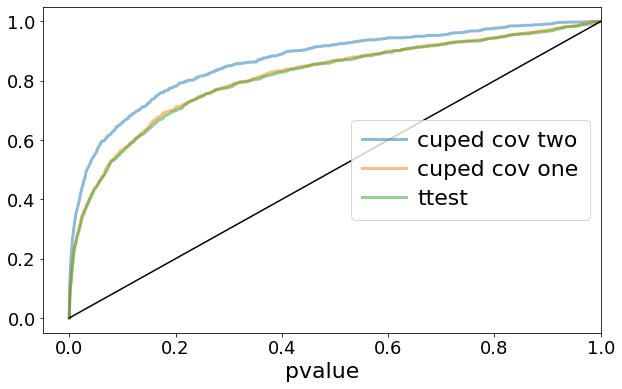

In [21]:
sample_size = 10000
pvalues_ttest = []
pvalues_cuped_cov_one = []
pvalues_cuped_cov_two = []

for corr in tqdm(corrs):
    control_users, pilot_users = np.random.choice(df_metrics.index, (2, sample_size,), False)
    df_control = df_metrics.loc[control_users]
    df_pilot = df_metrics.loc[pilot_users]
    df_pilot['metric'] += 20
    pvalues_ttest.append(check_test(df_control, df_pilot))
    pvalues_cuped_cov_one.append(check_cuped_test(df_control, df_pilot, 'cov_one'))
    pvalues_cuped_cov_two.append(check_cuped_test(df_control, df_pilot, 'cov_two'))


list_pvalues = [pvalues_ttest, pvalues_cuped_cov_one, pvalues_cuped_cov_two]
list_titles = ['ttest', 'cuped cov one', 'cuped cov two']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.xlim([-0.05, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

- CUPED с ковариатой стоимость покупок за 1 неделю до эксперимента 
практически совпадает по мощности с t-test.
- CUPED с ковариатой стоимость покупок за 4 неделю до эксперимента заметно лучше по мощности чем t-test.

## CUPED + ML

Попробуем построить ковариату с ещё большей корреляцией с помощью алгоритмов машинного обучения.

In [22]:
from lightgbm import LGBMRegressor

In [23]:
def get_features(df, user_ids, date):
    """Генерирует признаки для предсказания.

    Признаки - стоимости покупок по неделям за 4 недели.
    """
    features = [pd.DataFrame(index=user_ids)]
    for delta in range(0, 22, 7):
        date_begin = date - timedelta(delta + 7)
        date_end = date - timedelta(delta)
        features.append(
            df_sales
            [(df_sales['date'] >= date_begin) & (df_sales['date'] < date_end)]
            .groupby('user_id')[['price']].sum()
            .rename(columns={'price': f'delta_{delta}'})
        )
    df_features = pd.concat(features, axis=1).loc[user_ids].fillna(0)
    return df_features

# данные для обучения
df_y_train = (
    df_sales
    [
      (df_sales['date'] >= begin_exp_date - timedelta(7))
      & (df_sales['date'] < end_exp_date - timedelta(7))
    ]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
)
df_x_train = get_features(df_sales, df_y_train.index, begin_exp_date - timedelta(7))
# данные для прогноза
df_x_test = get_features(df_sales, df_metrics.index, begin_exp_date)

**данные**

неделя 1, неделя 2, неделя 3, неделя 4, неделя 5, неделя 6


**train**

признаки (неделя 1, неделя 2, неделя 3, неделя 4) -> прогноз (неделя 5)

**test**

признаки (неделя 2, неделя 3, неделя 4, неделя 5) -> прогноз (неделя 6)

In [24]:
# обучение модели
model = LGBMRegressor()
model.fit(df_x_train.values, df_y_train['metric'].values)

# предсказание модели
predict = model.predict(df_x_test.values)

In [25]:
df_metrics['predict'] = predict
df_metrics.corr()

,metric,cov_one,cov_two,predict
metric,1.000000,0.101480,0.503251,0.761580
cov_one,0.101480,1.000000,0.439640,0.155329
cov_two,0.503251,0.439640,1.000000,0.657252
predict,0.761580,0.155329,0.657252,1.000000


Получили новую ковариату, которая имеет корреляцию больше предыдущих.

  0%|          | 0/1000 [00:00<?, ?it/s]

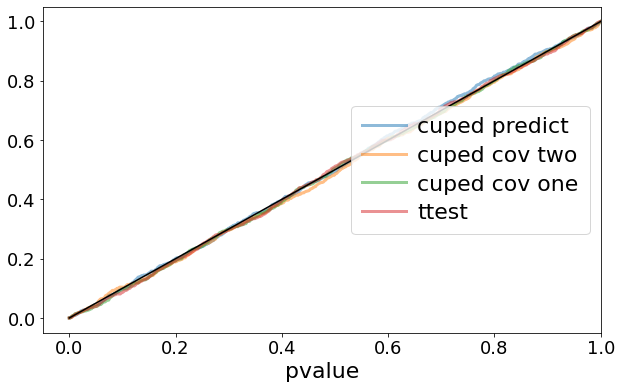

In [26]:
sample_size = 10000
pvalues_ttest = []
pvalues_cuped_cov_one = []
pvalues_cuped_cov_two = []
pvalues_cuped_predict = []

for corr in tqdm(corrs):
    control_users, pilot_users = np.random.choice(df_metrics.index, (2, sample_size,), False)
    df_control = df_metrics.loc[control_users]
    df_pilot = df_metrics.loc[pilot_users]
    df_pilot['metric'] += 0
    pvalues_ttest.append(check_test(df_control, df_pilot))
    pvalues_cuped_cov_one.append(check_cuped_test(df_control, df_pilot, 'cov_one'))
    pvalues_cuped_cov_two.append(check_cuped_test(df_control, df_pilot, 'cov_two'))
    pvalues_cuped_predict.append(check_cuped_test(df_control, df_pilot, 'predict'))


list_pvalues = [pvalues_ttest, pvalues_cuped_cov_one, pvalues_cuped_cov_two, pvalues_cuped_predict]
list_titles = ['ttest', 'cuped cov one', 'cuped cov two', 'cuped predict']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.xlim([-0.05, 1])
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()